# Tutorial 10: Adversarial attacks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under%20development&color=red)

**Filled notebook:** 
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)

**Pre-trained models and dataset:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial10)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1k01P6w31VOW9TT0gTEP9kog315qyiXCd?usp=sharing)

In this tutorial, we will discuss adversarial attacks on deep image classification models. As we have seen in many of the previous tutorials so far, Deep Neural Networks are a very powerful tool to recognize patterns in data, and, for example, perform image classification on human-level. However, we have not tested yet how robust these models actually are. Can we "trick" the model and find failure modes? Can we design images that the networks naturally classify incorrectly? Due to the high classification accuracy on unseen test data, we would expect that this can be difficult. However, in 2014, a research group at Google and NYU showed that deep CNNs can be easily fooled, just by adding some salient, but carefully constructed noise to the images. For instance, take a look at the example below (figure credit - [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf)):

<center width="100%" style="padding: 20px"><img src="adversarial_example.svg" width="550px"></center>

The image on the left is the original image from ImageNet, and a deep CNN classifies the image correctly as "panda" with a class likelihood of 57%. Nevertheless, if we add a little noise to every pixel of the image, the prediction of the model changes completely. Instead of a panda, our CNN tells us that the image contains a "gibbon" with a confidence of over 99%. For a human, however, these two images looks exactly alike, and you cannot distinguish which one has noise added and which doesn't. While this first seems like a fun game to fool trained networks, it can have a serious impact on the usage of neural networks. More and more deep learning models are used in applications, such as for example autonomous driving. Imagine that someone who gains access to the camera input of the car, could make pedestrians "disappear" for the image understanding network by simply adding some noise to the input as shown below (figure taken from [J.H. Metzen et al.](https://openaccess.thecvf.com/content_ICCV_2017/papers/Metzen_Universal_Adversarial_Perturbations_ICCV_2017_paper.pdf)). The first row shows the original image with the semantic segmentation output on the right (pedestrians red), while the second row shows the image with small noise and the corresponding segmentation prediction. The pedestrian becomes invisible for the network, and the car would think the road is clear ahead.

<center width="100%" style="padding: 40px"><img src="adversarial_attacks_cityscapes_3.png" width="700px"></center>

Some attack types don't even require to add noise, but minor changes on a stop sign can be already sufficient for the network to recognize it as a "50km/h" speed sign ([paper](https://arxiv.org/pdf/1707.08945.pdf), [paper](https://arxiv.org/pdf/1802.06430.pdf)). The consequences of such attacks can be devastating. Hence, every deep learning engineer who designs models for an application, should be aware of the possibility of adversarial attacks.

To understand what makes CNNs vulnerable to such attacks, we will implement our own adversarial attack strategies in this notebook, and try to fool a deep neural network. Let's being with importing our standard libraries:

In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.0.3
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


We have again a few download statements. This includes both a dataset, and a few pretrained patches we will use later.

In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

## Deep CNNs on ImageNet

For our experiments in this notebook, we will use common CNN architectures trained on the ImageNet dataset. Such models are luckily provided by PyTorch's torchvision package, and hence we just need to load the model of our preference. For the results on the website and default on Google Colab, we use a ResNet34. Feel free to experiment with other architectures as well, the code is mainly independent of the specific architecture we choose.

In [3]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

To perform adversarial attacks, we also need a dataset to work on. Given that the CNN model has been trained on ImageNet, it is only fair to perform the attacks on data from ImageNet. For this, we provide a small set of pre-processed images from the original ImageNet dataset. Specifically, we have 5 images for each of the 1000 labels of the dataset. We can load the data below, and create a corresponding data loader.

In [4]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), "Could not find the ImageNet dataset at expected path \"%s\". " % imagenet_path + \
                                     "Please make sure to have downloaded the ImageNet dataset here, or change the DATASET_PATH variable (currently set to %s)." % DATASET_PATH
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, "Label \"%s\" not found. Check the spelling of the class." % lab_str
    return label_names.index(lab_str)

Before we start with our attacks, we should verify the performance of our model. As ImageNet has 1000 classes, simply looking at the accuracy is not sufficient to tell the performance of a model. Imagine a model which always predicts the true label as second highest class in its softmax ouptut. Although we would say it recognizes the object in the image, it achieves an accuracy of 0. In ImageNet with 1000 classes, there is not always one clear label we can assign an image to. This is why for image classifications over so many classes, a common alternative metric is "Top-5 accuracy", which tells us how many times the true label has been within the 5 most-likely predictions of the model. As models usually perform quite well on those, we report the error (1 - accuracy) instead of the accuracy:

In [5]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print("Top-1 error: %4.2f%%" % (100.0 * (1 - acc)))
    print("Top-5 error: %4.2f%%" % (100.0 * (1 - top5)))
    return acc, top5

In [6]:
_ = eval_model(data_loader)


Top-1 error: 19.10%
Top-5 error: 4.30%


The ResNet34 achives a decent error rate of 4.3% for the top-5 predictions. Next, we can look at some predictions of the model to get more familiar with the dataset. The function below plots an image along with a bar diagram of its predictions. We also prepare it to show adversarial examples for later applications.

In [7]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

Let's visualize a few images below:

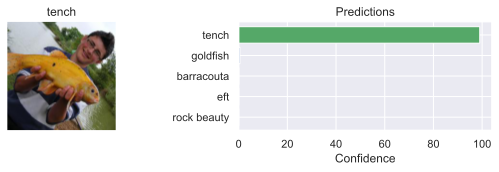

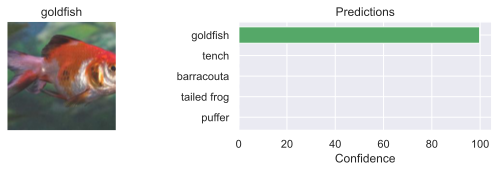

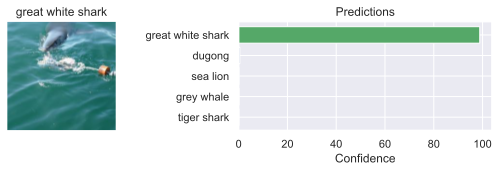

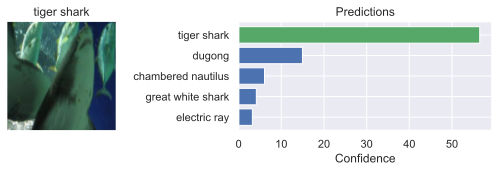

In [8]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

The bar plot on the right shows the top-5 predictions of the model with their class probabilties. We denote the class probabilities with "confidence" as it somewhat resembles how confident the network is that the image is of one specific class. Some of the images have a highly peaked probability distribution, and we would expect the model to be rather robust against noise for those. However, we will see below that this is not always the case. Note that all of the images are of fish because the data loader doesn't shuffle the dataset. Otherwise we would get different images every time we run the notebook, which would make it hard to discuss the results on the static version.

## White-box adversarial attacks

There have been proposed many possible adversarial attack strategies, which all share the same goal: alternate the data/image input only a little bit to have a great impact on the model's prediction. Specifically, if we look at the ImageNet predictions above, how can we have to change the image of the goldfish so that the model does not recognize the goldfish anymore? At the same time, the label of the image should not change, in the sense that a human would still clearly classify it as a goldfish. 

Adversarial attacks are usually grouped into "white-box" and "black-box" attacks. White-box attacks assume that wehave access to the model parameter and can, for example, calculate the gradients with respect to the input. Black-box attacks on the other hand have the harder task of not having any knowledge about the network, and can only obtain predictions for an image, but no gradients or the like. In this notebook, we will focus on white-box attacks as they are usually easier to implement, and follow the intuition of Generative Adversarial Networks (GAN) as studied in lecture 10.

### Fast Gradient Sign Method (FGSM)

One of the first attack strategies proposed is Fast Gradient Sign Method (FGSM), developed by [Ian Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf) in 2014. Given an image, we create an adversarial example by the following expression:

$$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta,x,y))$$

The term $J(\theta,x,y)$ represents the loss of the network for classifying input image $x$ as label $y$; $\epsilon$ is the intensity of the noise, and $\tilde{x}$ the final adversarial example. The equation resembles SGD, and is actually nothing else than that. We change the input image $x$ in the direction of *maximizing* the loss $J(\theta,x,y)$. This is exactly the other way round as during training, where we try to minimize the loss. The sign function and $\epsilon$ can be seen as gradient clipping and learning rate specifically. We only allow our attack to change each pixel value by $\epsilon$. You can also see that the attack can be performed very fast, as it only requires a single forward and backward pass. Let's implement it below:

In [9]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

The default value of $\epsilon=0.02$ corresponds to changing a pixel value by about 1 in the range of 0 to 255, e.g. changing 127 to 128. This difference is marginal and can often not be recognized by humans. Let's try it below on our example images:

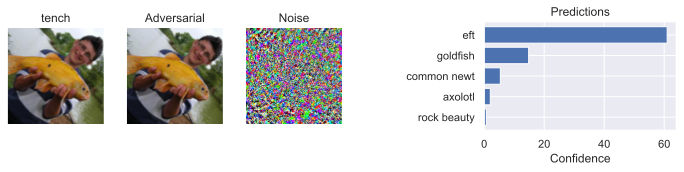

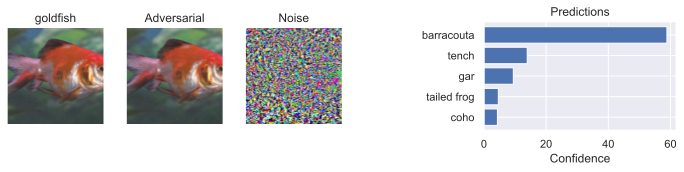

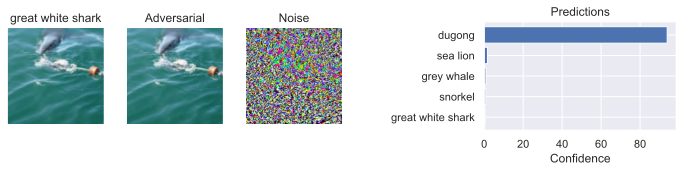

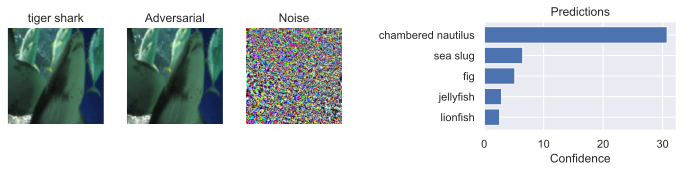

In [10]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))
    
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

Despite the minor amount of noise, we are able to fool the network on all of our examples. None of the labels have made it into the top-5 for the four images, showing that we indeed fooled the model. We can also check the accuracy of the model on the adversarial images:

In [11]:
_ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])


Top-1 error: 93.56%
Top-5 error: 60.52%


As expected, the model is fooled on almost every image at least for the top-1 error, and more than half don't have the true label in their top-5. This is a quite significant difference compared to the error rate of 4.3% on the clean images. However, note that the predictions remain semantically similar. For instance, in the images we visualized above, the tench is still recognized as another fish, as well as the great white shark being a dugong. FSGM could be adapted to increase the probability of a specific class instead of minimizing the probability of a label, but for those there are usually better attacks such as the adversarial patch.

### Adversarial Patch

Adversarial Patch (https://arxiv.org/pdf/1712.09665.pdf)

In [12]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

def show_patch(patch, target_class):
    patch = patch.detach().cpu().permute(1, 2, 0).numpy()
    patch = (patch * NORM_STD[None,None]) + NORM_MEAN[None,None]
    patch = np.clip(patch, a_min=0.0, a_max=1.0)
    plt.imshow(patch)
    plt.title(label_names[target_class])
    plt.axis('off')
    plt.show()
    plt.close()

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description("Epoch %i, Loss: %4.2f" % (epoch, loss.item()))
    
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc.item(), "top5": top5.item()}

Load/save

In [13]:
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)
        
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t 
                                   for t in patch_dict[cname][psize]["results"]] 
                           for psize in patch_dict[cname]} 
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [14]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, "%s_%i_patch.pt" % (name, patch_size))
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print("Validation results for %s and %i:" % (name, patch_size), val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)    
            
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }
        
    return result_dict

In [15]:
class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple']
patch_sizes = [32, 48, 64]

patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you want to save the new results

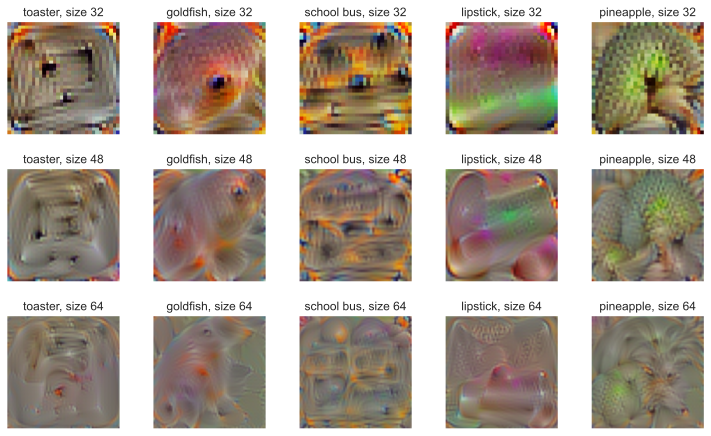

In [16]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.5, len(patch_sizes)*2.5))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = (patch * NORM_STD[None,None]) + NORM_MEAN[None,None]
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title("%s, size %i" % (cname, psize))
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

In [17]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [18]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + ["%4.2f%%" % (100.0 * patch_dict[name][psize]["results"][i]) for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + ["Patch size %ix%i" % (psize, psize) for psize in patch_sizes])))

In [19]:
show_table(top_1=True)

Class name,Patch size 32x32,Patch size 48x48,Patch size 64x64
toaster,48.89%,90.48%,98.58%
goldfish,69.53%,93.53%,98.34%
school bus,78.79%,93.95%,98.22%
lipstick,43.36%,86.05%,96.41%
pineapple,79.74%,94.48%,98.72%


In [20]:
show_table(top_1=False)

Class name,Patch size 32x32,Patch size 48x48,Patch size 64x64
toaster,72.02%,98.12%,99.93%
goldfish,86.31%,99.07%,99.95%
school bus,91.64%,99.15%,99.89%
lipstick,70.10%,96.86%,99.73%
pineapple,92.23%,99.26%,99.96%


In [21]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

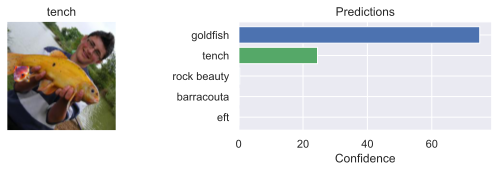

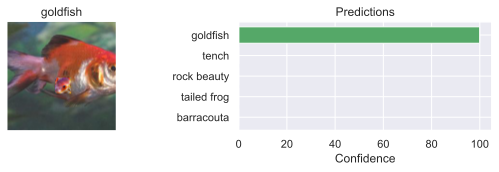

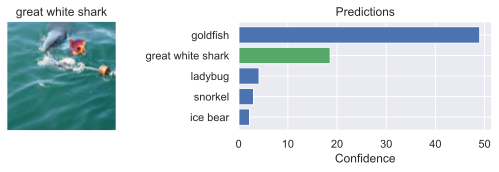

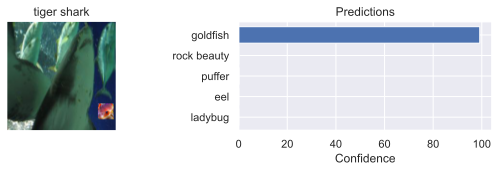

In [22]:
perform_patch_attack(patch_dict['goldfish'][32]['patch'])

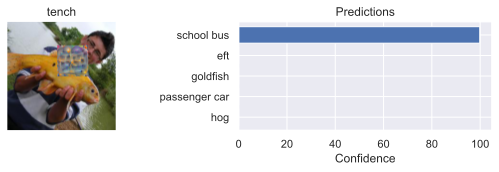

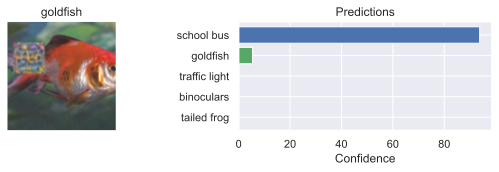

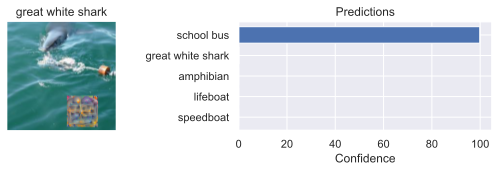

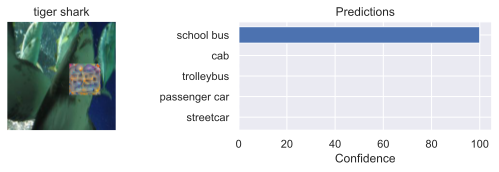

In [23]:
perform_patch_attack(patch_dict['school bus'][64]['patch'])

## Transferibility of white-box attacks

In [24]:
# another_network = torchvision.models.mobilenet_v2(pretrained=True)
# another_network = another_network.to(device)

In [25]:
# _ = eval_patch(another_network, patch, data_loader, target_class=get_label_index('toaster'))

## Protecting against adversarial attacks

## Conclusion

## References

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.